# EECS 6893 Final Project Visualize Vessle Images (Training, Validation and Test)
In this notebook, we will visualize the images generated based on the maritime vessel data. Since data is a bit noisy, this will help us identify issues with the date:

  * Bad data (mobility pattern is not good, image shows very random mobility pattern)
  * Mis-labeled data (mobility pattern is mis-classified)
  * Data imbalance (few labeled data for some mobility patterns compared to other mobility patterns)


In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.4


We will use IMG_SIZE of 224 x 224 and BATCH_SIZE of 32.

In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 224
SHUFFLE_SIZE = 1000
EPOCHS = 10

### Utility functions

In [3]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_png(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

In [4]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

## Download data from S3 bucket

In [5]:
# S3 and local directories
train_s3_dir = 's3://eecse-6893-track-images/train/'
valid_s3_dir = 's3://eecse-6893-track-images/validate/'
test_s3_dir = 's3://eecse-6893-track-images/test/'

train_dir = 'content/eecse-6893-track-images/train'
valid_dir = 'content/eecse-6893-track-images/validate'
test_dir = 'content/eecse-6893-track-images/test'

In [6]:
!mkdir -p 'content/eecse-6893-track-images/train'
!mkdir -p 'content/eecse-6893-track-images/validate'
!mkdir -p 'content/eecse-6893-track-images/test'

### Download training data

In [7]:
# copy from S3 to local
!aws s3 cp --recursive 's3://eecse-6893-track-images/train/' 'content/eecse-6893-track-images/train'

download: s3://eecse-6893-track-images/train/Anchored/IMO1002275-2015-08-19-2015-08-19.png to content/eecse-6893-track-images/train/Anchored/IMO1002275-2015-08-19-2015-08-19.png
download: s3://eecse-6893-track-images/train/Anchored/IMO0000101-2015-09-03-2015-09-03.png to content/eecse-6893-track-images/train/Anchored/IMO0000101-2015-09-03-2015-09-03.png
download: s3://eecse-6893-track-images/train/Anchored/IMO1002275-2015-08-22-2015-08-22.png to content/eecse-6893-track-images/train/Anchored/IMO1002275-2015-08-22-2015-08-22.png
download: s3://eecse-6893-track-images/train/Anchored/IMO1002275-2015-08-20-2015-08-20.png to content/eecse-6893-track-images/train/Anchored/IMO1002275-2015-08-20-2015-08-20.png
download: s3://eecse-6893-track-images/train/Anchored/IMO1010894-2015-08-15-2015-08-15.png to content/eecse-6893-track-images/train/Anchored/IMO1010894-2015-08-15-2015-08-15.png
download: s3://eecse-6893-track-images/train/Anchored/IMO1002275-2015-08-20-2015-08-21.png to content/eecse-68

### Download validation data

In [13]:
!aws s3 cp --recursive 's3://eecse-6893-track-images/validate/' 'content/eecse-6893-track-images/validate'

download: s3://eecse-6893-track-images/validate/Anchored/IMO7390923-2015-09-08-2015-09-10.png to content/eecse-6893-track-images/validate/Anchored/IMO7390923-2015-09-08-2015-09-10.png
download: s3://eecse-6893-track-images/validate/Anchored/IMO6608608-2015-09-06-2015-09-10.png to content/eecse-6893-track-images/validate/Anchored/IMO6608608-2015-09-06-2015-09-10.png
download: s3://eecse-6893-track-images/validate/Anchored/IMO7816551-2015-09-07-2015-09-07.png to content/eecse-6893-track-images/validate/Anchored/IMO7816551-2015-09-07-2015-09-07.png
download: s3://eecse-6893-track-images/validate/Anchored/IMO7816551-2015-09-07-2015-09-10.png to content/eecse-6893-track-images/validate/Anchored/IMO7816551-2015-09-07-2015-09-10.png
download: s3://eecse-6893-track-images/validate/Anchored/IMO7390923-2015-09-07-2015-09-07.png to content/eecse-6893-track-images/validate/Anchored/IMO7390923-2015-09-07-2015-09-07.png
download: s3://eecse-6893-track-images/validate/Anchored/IMO8003307-2015-09-10-2

In [14]:
!aws s3 cp --recursive 's3://eecse-6893-track-images/test/' 'content/eecse-6893-track-images/test'

download: s3://eecse-6893-track-images/test/Anchored/IMO7502576-2015-09-12-2015-09-13.png to content/eecse-6893-track-images/test/Anchored/IMO7502576-2015-09-12-2015-09-13.png
download: s3://eecse-6893-track-images/test/Anchored/IMO7502576-2015-09-11-2015-09-12.png to content/eecse-6893-track-images/test/Anchored/IMO7502576-2015-09-11-2015-09-12.png
download: s3://eecse-6893-track-images/test/Anchored/IMO7502576-2015-09-12-2015-09-12.png to content/eecse-6893-track-images/test/Anchored/IMO7502576-2015-09-12-2015-09-12.png
download: s3://eecse-6893-track-images/test/Anchored/IMO8333207-2015-09-11-2015-09-13.png to content/eecse-6893-track-images/test/Anchored/IMO8333207-2015-09-11-2015-09-13.png
download: s3://eecse-6893-track-images/test/Anchored/IMO8765709-2015-09-11-2015-09-13.png to content/eecse-6893-track-images/test/Anchored/IMO8765709-2015-09-11-2015-09-13.png
download: s3://eecse-6893-track-images/test/Anchored/IMO8815023-2015-09-11-2015-09-13.png to content/eecse-6893-track-im

In [8]:
image_labels = [ 'Anchored', 'Fishing', 'Moored', 'Underway' ]

## Explore training data of mobility pattern images

In [9]:
# Prepare dataset of mobility pattern images

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using the keras preprocessing utilities here instead of tf.data

# You will need to add data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 1273 images belonging to 4 classes.


In [10]:
from collections import Counter

counter = Counter(train_generator.classes)
for item in counter.items():
    print("Training images for label " + image_labels[item[0]] + ': ' + str(item[1]))

Training images for label Anchored: 305
Training images for label Fishing: 238
Training images for label Moored: 271
Training images for label Underway: 459


| Pattern | Number of Training Images |
| --- | :---: |
| Anchored | 305 |
| Fishing | 238 |
| Moored | 271 |
| Underway | 459 |

### Visualize training data

Training Anchored pattern images:


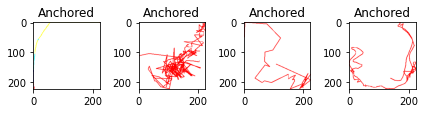

Training Fishing pattern images:


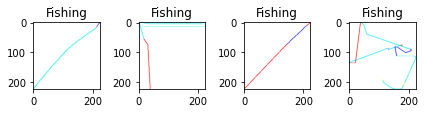

Training Moored pattern images:


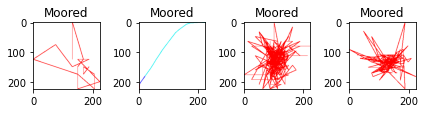

Training Underway pattern images:


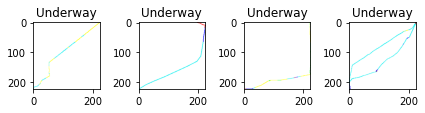

In [11]:
import os
for label in image_labels:
    train_imgs_path = train_dir + '/' + label + '/'
    tc_files = os.listdir(train_imgs_path)
    print('Training ' + label + ' pattern images:')
    fig=plt.figure()
    cols = 4
    i = 0
    for f in tc_files:
      fpath = os.path.join(train_imgs_path, f)
      img = load_and_preprocess_image(fpath)
      i = i + 1
      fig.add_subplot(1, cols, i)
      plt.imshow(img)
      plt.title(label)
      if i == cols:
        break

    fig.tight_layout()    
    plt.show()

## Explore validation data

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# validation data
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 532 images belonging to 4 classes.


In [16]:
from collections import Counter

counter = Counter(valid_generator.classes)
for item in counter.items():
    print("Validation images for label " + image_labels[item[0]] + ': ' + str(item[1]))

Validation images for label Anchored: 230
Validation images for label Fishing: 80
Validation images for label Moored: 95
Validation images for label Underway: 127


| Pattern | Number of Validation Images |
| --- | :---: |
| Anchored | 230 |
| Fishing | 80 |
| Moored | 95 |
| Underway | 127 |

### Visualize validation data

Validation Anchored pattern images:


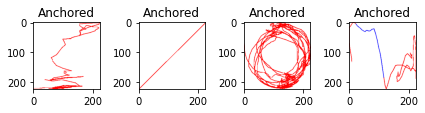

Validation Fishing pattern images:


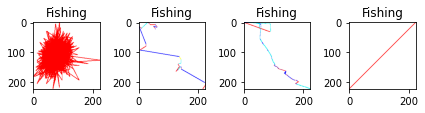

Validation Moored pattern images:


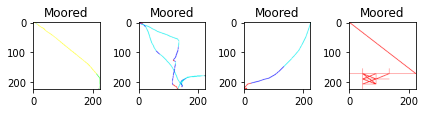

Validation Underway pattern images:


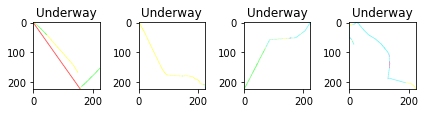

In [17]:
import os
for label in image_labels:
    valid_imgs_path = valid_dir + '/' + label + '/'
    tc_files = os.listdir(valid_imgs_path)
    print('Validation ' + label + ' pattern images:')
    fig=plt.figure()
    cols = 4
    i = 0
    for f in tc_files:
      fpath = os.path.join(valid_imgs_path, f)
      img = load_and_preprocess_image(fpath)
      i = i + 1
      fig.add_subplot(1, cols, i)
      plt.imshow(img)
      plt.title(label)
      if i == cols:
        break

    fig.tight_layout()    
    plt.show()

## Explore Testing data

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

Found 264 images belonging to 4 classes.


In [19]:
from collections import Counter

counter = Counter(test_generator.classes)
for item in counter.items():
    print("Test images for label " + image_labels[item[0]] + ': ' + str(item[1]))

Test images for label Anchored: 108
Test images for label Fishing: 49
Test images for label Moored: 31
Test images for label Underway: 76


| Pattern | Number of Test Images |
| --- | :---: |
| Anchored | 108 |
| Fishing | 49 |
| Moored | 31 |
| Underway | 76 |

Test Anchored pattern images:


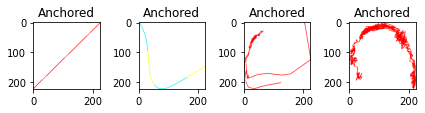

Test Fishing pattern images:


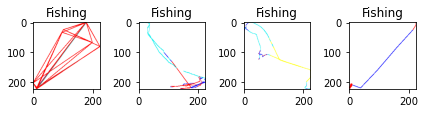

Test Moored pattern images:


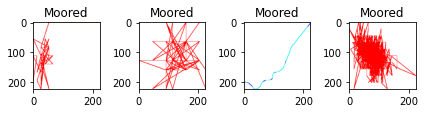

Test Underway pattern images:


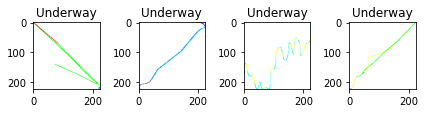

In [20]:
import os
for label in image_labels:
    test_imgs_path = test_dir + '/' + label + '/'
    tc_files = os.listdir(test_imgs_path)
    print('Test ' + label + ' pattern images:')
    fig=plt.figure()
    cols = 4
    i = 0
    for f in tc_files:
      fpath = os.path.join(test_imgs_path, f)
      img = load_and_preprocess_image(fpath)
      i = i + 1
      fig.add_subplot(1, cols, i)
      plt.imshow(img)
      plt.title(label)
      if i == cols:
        break

    fig.tight_layout()    
    plt.show()